# Imports

In [1]:
import string

In [2]:
import numpy as np

In [3]:
import pandas as pd

In [4]:
import matplotlib.pyplot as plt
import seaborn as sns

In [5]:
from sklearn.compose import ColumnTransformer
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier, DecisionTreeRegressor, ExtraTreeClassifier
from sklearn.dummy import DummyClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.feature_selection import SelectKBest
from sklearn.linear_model import LogisticRegression, LinearRegression, SGDRegressor
from sklearn.model_selection import train_test_split, GridSearchCV, RandomizedSearchCV, KFold
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import LabelEncoder, KBinsDiscretizer, OneHotEncoder, StandardScaler, MaxAbsScaler, Normalizer, OrdinalEncoder, MinMaxScaler
from sklearn.metrics import accuracy_score, f1_score, ConfusionMatrixDisplay, mean_absolute_error, mean_squared_error, mean_squared_log_error, r2_score
from sklearn.model_selection import cross_val_score
from sklearn.inspection import permutation_importance
from sklearn.impute import SimpleImputer
from sklearn.decomposition import TruncatedSVD

In [6]:
from scipy.stats import randint, uniform

# Functions

In [7]:
def inspect_df(df : pd.DataFrame):
    """
    Display basic structural information about a DataFrame.

    This function prints the number of rows and columns, checks for
    missing values, and displays the data types of each feature.

    Parameters
    ----------
    df : pandas.DataFrame
        The DataFrame to be inspected.

    Returns
    -------
    None
        This function does not return any value. It prints
        summary information to the console.

    Notes
    -----
    - If no missing values are present, the function explicitly
      prints that there are zero null values.
    - If missing values exist, the function prints the number
      of null values for each column.
    - Feature data types are displayed using `df.dtypes`.
    """
    print(f'Rows:       {df.shape[0]}')
    print(f'Columns:    {df.shape[1]}')
    print("-" * 30)

    null_values = df.isna().sum()
    if (null_values.sum() == 0):
        print('Null values: 0')
    else:
        print('Null values:')
        print(null_values)
    
    print("-" * 30)
    print('Feature data types:')
    print(df.dtypes)
    print("")

In [8]:
def check_balance(df : pd.DataFrame, target_col : str):
    """
    Check the class distribution of a target column in a dataset.

    This function computes the percentage distribution of each class
    in the specified target column and prints the results. It also
    displays the ideal percentage share per class for a perfectly
    balanced dataset.

    Parameters
    ----------
    df : pandas.DataFrame
        The input DataFrame containing the dataset.
    target_col : str
        Name of the target column whose class distribution
        needs to be evaluated.

    Returns
    -------
    None
        This function does not return any value. It prints
        the class distribution and balance information.

    Notes
    -----
    - Percentages are computed using normalized value counts
      and rounded to two decimal places.
    - The dataset can be considered balanced if the class
      percentages are close to the ideal equal share
      (100 / number_of_classes).
    - The function assumes that `target_col` exists in `df`.
    """
    value_counts = (df[target_col].value_counts(normalize=True) * 100).round(2)
    ideal_share = 100 / len(value_counts)
    
    print(f'Value counts for {target_col}:')
    print(value_counts)
    print("-" * 30)
    print(f'The dataset is balanced if the value counts are close to {ideal_share:.2f}%')

In [9]:
def evaluate_classifier(
        model, 
        x_test : pd.DataFrame, 
        y_test : pd.Series, 
        title: str, 
        f1_average: str = 'binary', 
        f1_pos_label = 1
    ):
    """
    Evaluate the performance of a classification model on a test dataset.

    This function computes Accuracy and F1-score, prints the results,
    and displays the confusion matrix normalized by rows.

    Parameters
    ----------
    model : estimator
        A trained classification model implementing the `predict` method.
    x_test : array-like
        Feature matrix of the test dataset.
    y_test : array-like
        True labels corresponding to `x_test`.
    title : str
        Descriptive title to display in the output and on the confusion matrix plot.
    f1_average : str, default='binary'
        Averaging method used to compute the F1-score.
        Common options include: 'binary', 'micro', 'macro', 'weighted'.
    f1_pos_label : int or str, default=1
        The label considered as the positive class when `f1_average='binary'`.

    Returns
    -------
    y_pred : array-like
        Predicted labels generated by the model on `x_test`.

    Notes
    -----
    - The confusion matrix is displayed normalized by rows (`normalize='true'`),
      meaning values represent proportions relative to the true class.
    - Metrics are printed with four decimal places.
    """
    y_pred = model.predict(x_test)
    accuracy = accuracy_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred, average=f1_average, pos_label=f1_pos_label)

    print("")
    print(f"{title.title()}:")
    print(f"Accuracy:                   {accuracy:.4f}")
    print(f"F1 score ({f1_average}):        {f1:.4f}")

    disp = ConfusionMatrixDisplay.from_predictions(
        y_pred, y_test,
        cmap=plt.cm.Blues, 
        normalize='true'    # 'true' normalize on rows
    )
    disp.ax_.set_title(title.title())
    plt.show()

    return y_pred

In [10]:
def evaluate_regressor(model, x_test : pd.DataFrame, y_test : pd.Series, title : str):
    """
    Evaluate the performance of a regression model on a test dataset.

    This function generates predictions using the provided model and
    computes common regression metrics: MAE, MSE, MSLE (if applicable),
    and R² score. The results are printed to the console.

    Parameters
    ----------
    model : estimator
        A trained regression model implementing the `predict` method.
    x_test : array-like
        Feature matrix of the test dataset.
    y_test : array-like
        True target values corresponding to `x_test`.

    Returns
    -------
    y_pred : array-like
        Predicted values generated by the model on `x_test`.

    Notes
    -----
    - MAE (Mean Absolute Error) measures the average absolute difference
      between true and predicted values.
    - MSE (Mean Squared Error) penalizes larger errors more heavily.
    - MSLE (Mean Squared Logarithmic Error) is computed only if all true
      and predicted values are greater than -1. Otherwise, it is not
      applicable.
    - R² score is bounded in the interval (-∞, 1]. Values below 0
      indicate that the model performs worse than a baseline model
      predicting the mean target value.
    """
    y_pred = model.predict(x_test)

    mae = mean_absolute_error(y_test, y_pred)
    mse = mean_squared_error(y_test, y_pred)
    if (y_test > -1).all() & (y_pred > -1).all():
        msle = mean_squared_log_error(y_test, y_pred)
    else:
        msle = "N/A (y_test contiene valori <= -1)"
    r2 = r2_score(y_test, y_pred)

    print(f"{title.title()}:")
    print(f"MAE:    {mae}")
    print(f"MSE:    {mse}")
    print(f"MSLE:   {msle}")
    print(f"R2:     {r2}")
    print("")
    print("Remember: R2 score is in [-inf, 1]. R2<0 --> BAD MODEL.")
    print("")

    return y_pred

In [11]:
def kfold_crossvalidation(
        model, 
        x_train : pd.DataFrame, 
        y_train : pd.Series, 
        cv : int, 
        title : str
    ):
    """
    Perform K-Fold cross-validation on a given model.

    This function evaluates a model using cross-validation,
    prints the mean and standard deviation of the obtained
    scores, and returns the full array of cross-validation results.

    Parameters
    ----------
    model : estimator
        A machine learning model implementing the scikit-learn API.
    x_train : array-like
        Feature matrix of the training dataset.
    y_train : array-like
        Target values corresponding to `x_train`.
    cv : int
        Number of folds for K-Fold cross-validation.
        (Note: the current implementation uses `cv=10` internally.)
    title : str
        Descriptive title to display in the printed output.

    Returns
    -------
    outputs : numpy.ndarray
        Array containing the cross-validation scores for each fold.

    Notes
    -----
    - Cross-validation is performed using `cross_val_score`
      with parallel processing enabled (`n_jobs=-1`).
    - The function prints the mean and standard deviation
      of the cross-validation scores.
    """
    outputs = cross_val_score(model, x_train, y_train, cv=cv, n_jobs=-1)

    print(f'{title.title()}:')
    print(f'Mean:   {outputs.mean()}')
    print(f'Std:    {outputs.std()}')
    print('-' * 30)
    return outputs

In [12]:
def get_categorical_features(df : pd.DataFrame):
    return df.select_dtypes(include=['object']).columns

In [13]:
def get_k_correlated(df : pd.DataFrame, y_name : str, k : int, abs : bool, ascending : bool):
    """
    Retrieve the names of the top-k features most correlated with a target variable.

    This function computes the correlation matrix of the DataFrame and
    returns the names of the k features with the highest (or lowest)
    correlation with the specified target column.

    Parameters
    ----------
    df : pandas.DataFrame
        The input DataFrame containing numerical features.
    y_name : str
        Name of the target column for which correlations are computed.
    k : int
        Number of correlated features to retrieve.
    abs : bool
        If True, correlations are sorted by their absolute values.
        If False, raw correlation values are used.
    ascending : bool
        Sorting order of correlations.
        If True, correlations are sorted in ascending order.
        If False, correlations are sorted in descending order.

    Returns
    -------
    pandas.Index
        Index containing the names of the top-k correlated features,
        excluding the target variable itself.

    Notes
    -----
    - The function assumes that `y_name` exists in `df` and that the
      DataFrame contains only numerical columns for correlation computation.
    - The first element (self-correlation of the target) is excluded
      from the result.
    """
    if (abs):
        y_corr = df.corr()[y_name].abs().sort_values(ascending=ascending)
    else:
        y_corr = df.corr()[y_name].sort_values(ascending=ascending)
    return y_corr[1:(k+1)].index

In [14]:
def pfi(
    model,
    features: list[str],
    x_test: pd.DataFrame,
    y_test: pd.Series,
    n_repeats: int
):
    """
    Compute and display Permutation Feature Importance (PFI)
    for a selected subset of features.

    This function calculates permutation importance for all features
    in the test set and then plots the importance (mean and standard
    deviation) only for the specified subset of features.

    Parameters
    ----------
    model : estimator
        A trained machine learning model implementing the scikit-learn API.
    features : list of str
        List of feature names to be displayed in the importance plot.
        These must be present in `x_test.columns`.
    x_test : pandas.DataFrame
        Feature matrix of the test dataset.
    y_test : pandas.Series
        True target values corresponding to `x_test`.
    n_repeats : int
        Number of times each feature is randomly shuffled to compute
        importance scores.

    Returns
    -------
    None
        This function does not return any value. It displays a bar plot
        of permutation feature importances for the selected features.

    Notes
    -----
    - Permutation importance measures the decrease in model performance
      when a feature’s values are randomly shuffled.
    - Higher importance values indicate that the model relies more heavily
      on the corresponding feature.
    - Error bars represent the standard deviation of importance across
      the `n_repeats` shuffles.
    - Parallel computation is enabled (`n_jobs=-1`).
    - The function assumes that all elements in `features` exist in
      `x_test.columns`.
    """
    pfi_result = permutation_importance(model, x_test, y_test, n_repeats=n_repeats, n_jobs=-1)
    
    importance_mean = pd.Series(
        pfi_result['importances_mean'], 
        index=x_test.columns
    )
    importance_std = pd.Series(
        pfi_result['importances_std'], 
        index=x_test.columns
    )
    
    fig, ax = plt.subplots()
    importance_mean[features].plot.bar(yerr=importance_std[features], ax=ax)
    ax.set_title("Permutation Feature Importance")
    ax.set_ylabel('Importance')
    ax.set_xlabel('Features')
    plt.xticks(rotation=45, ha='right')
    fig.tight_layout()
    plt.show()

In [15]:
def clean_text(text : str):
    text = text.lower()
    text = text.replace('\n', ' ').replace('\t', ' ').replace('\r', ' ')
    text = text.translate(str.maketrans('', '', string.punctuation))
    text = ' '.join(text.split())
    return text

# Exam

In [16]:
backup = pd.read_csv('./dataset.csv', sep=',')
df = backup.copy()
df.head()

,price,area,bedrooms,bathrooms,stories,mainroad,guestroom,basement,hotwaterheating,airconditioning,parking,prefarea,furnishingstatus
0,13300000,7420,4,2,3,yes,no,no,no,yes,2,yes,furnished
1,12250000,8960,4,4,4,yes,no,no,no,yes,3,no,furnished
2,12250000,9960,3,2,2,yes,no,yes,no,no,2,yes,semi-furnished
3,12215000,7500,4,2,2,yes,no,yes,no,yes,3,yes,furnished
4,11410000,7420,4,1,2,yes,yes,yes,no,yes,2,no,furnished


In [17]:
inspect_df(df)

Rows:       545
Columns:    13
------------------------------
Null values: 0
------------------------------
Feature data types:
price               int64
area                int64
bedrooms            int64
bathrooms           int64
stories             int64
mainroad              str
guestroom             str
basement              str
hotwaterheating       str
airconditioning       str
parking             int64
prefarea              str
furnishingstatus      str
dtype: object



In [18]:
df.groupby('mainroad')['price'].mean()

mainroad
no     3.398905e+06
yes    4.991777e+06
Name: price, dtype: float64

In [19]:
pivot = df[df['mainroad'] == 'yes'].pivot_table(index=['guestroom'], columns=['basement'], values=['price'], aggfunc='mean')
pivot

price              
basement             no           yes
guestroom                            
no         4.625947e+06  5.151417e+06
yes        6.277104e+06  5.807508e+06

<Axes: >

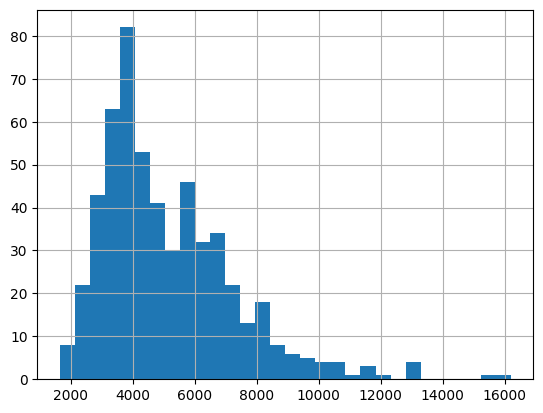

In [20]:
df['area'].hist(bins=30)

In [21]:
df['area'] = pd.cut(df['area'], bins=[1649, 3660, 6150, 9150, 13150, 16200])
df.head()

,price,area,bedrooms,bathrooms,stories,mainroad,guestroom,basement,hotwaterheating,airconditioning,parking,prefarea,furnishingstatus
0,13300000,"(6150, 9150]",4,2,3,yes,no,no,no,yes,2,yes,furnished
1,12250000,"(6150, 9150]",4,4,4,yes,no,no,no,yes,3,no,furnished
2,12250000,"(9150, 13150]",3,2,2,yes,no,yes,no,no,2,yes,semi-furnished
3,12215000,"(6150, 9150]",4,2,2,yes,no,yes,no,yes,3,yes,furnished
4,11410000,"(6150, 9150]",4,1,2,yes,yes,yes,no,yes,2,no,furnished


<Axes: xlabel='area'>

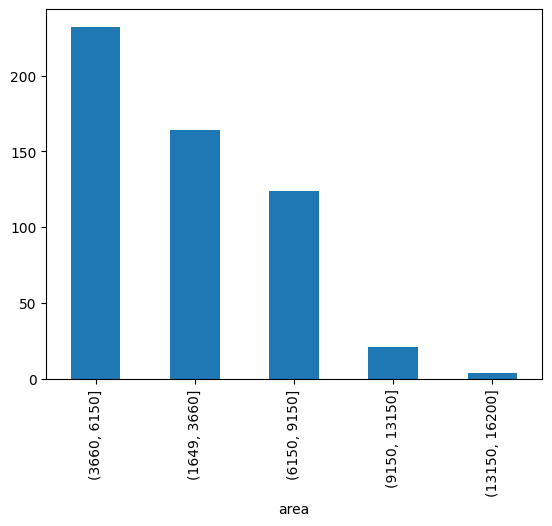

In [22]:
df['area'].value_counts().plot.bar()

<Axes: xlabel='area'>

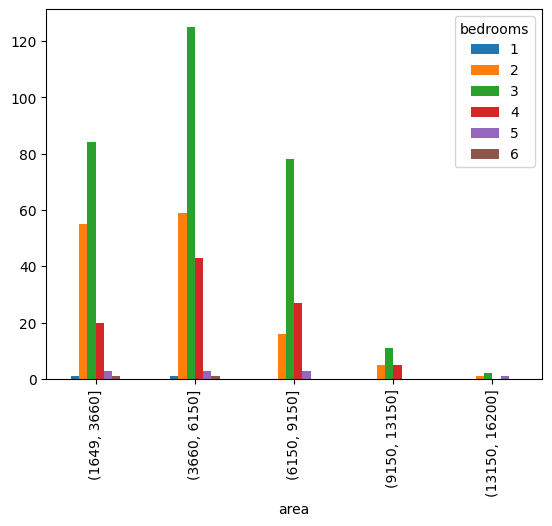

In [23]:
df.groupby(['area', 'bedrooms']).size().unstack(fill_value=0).plot.bar()

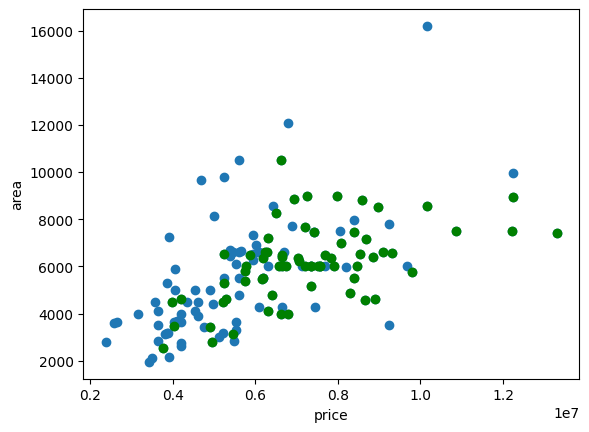

In [24]:
df['area'] = backup['area']
selected = df[(df['bathrooms'] >= 2) & (df['bedrooms'] >= 2)]
plt.scatter(selected['price'], selected['area'])
with_air = selected[selected['airconditioning'] == 'yes']
plt.scatter(with_air['price'], with_air['area'], color='g')
plt.xlabel('price')
plt.ylabel('area')
plt.show()

In [25]:
df = backup.copy()
df.head()

,price,area,bedrooms,bathrooms,stories,mainroad,guestroom,basement,hotwaterheating,airconditioning,parking,prefarea,furnishingstatus
0,13300000,7420,4,2,3,yes,no,no,no,yes,2,yes,furnished
1,12250000,8960,4,4,4,yes,no,no,no,yes,3,no,furnished
2,12250000,9960,3,2,2,yes,no,yes,no,no,2,yes,semi-furnished
3,12215000,7500,4,2,2,yes,no,yes,no,yes,3,yes,furnished
4,11410000,7420,4,1,2,yes,yes,yes,no,yes,2,no,furnished


In [26]:
df = df.dropna()

In [27]:
map = {
    'yes' : 1,
    'no' : 0
}

binary_cols = ['mainroad', 'guestroom', 'basement', 'hotwaterheating', 'airconditioning', 'prefarea']
for binary_col in binary_cols:
    df[binary_col] = df[binary_col].map(map)
df['furnishingstatus'] = LabelEncoder().fit_transform(df['furnishingstatus'])
df.head()

,price,area,bedrooms,bathrooms,stories,mainroad,guestroom,basement,hotwaterheating,airconditioning,parking,prefarea,furnishingstatus
0,13300000,7420,4,2,3,1,0,0,0,1,2,1,0
1,12250000,8960,4,4,4,1,0,0,0,1,3,0,0
2,12250000,9960,3,2,2,1,0,1,0,0,2,1,1
3,12215000,7500,4,2,2,1,0,1,0,1,3,1,0
4,11410000,7420,4,1,2,1,1,1,0,1,2,0,0


In [28]:
X, y = df.drop(columns='price'), df['price']
x_train, x_test, y_train, y_test = train_test_split(X, y, test_size=0.25)

In [29]:
lr = LinearRegression()
lr.fit(x_train, y_train)
evaluate_regressor(lr, x_train, y_train, 'linear regression - train data')
evaluate_regressor(lr, x_test, y_test, 'linear regression - test data')

Linear Regression - Train Data:
MAE:    762850.7291635206
MSE:    1080953780911.0303
MSLE:   0.04282743028436857
R2:     0.6855400873757576

Remember: R2 score is in [-inf, 1]. R2<0 --> BAD MODEL.

Linear Regression - Test Data:
MAE:    791876.0364622878
MSE:    1269456122254.4287
MSLE:   0.05323513410023078
R2:     0.6512935263934745

Remember: R2 score is in [-inf, 1]. R2<0 --> BAD MODEL.



array([5124470.34936757, 3685766.11483245, 4740244.8596981 ,
       4072428.56478943, 3574868.19265535, 4274553.6570085 ,
       5266665.64472902, 3179095.42540656, 4898002.82501725,
       4961441.81263556, 7948986.69519996, 4056641.58410317,
       3734560.99119953, 6180922.2454045 , 6315306.28629567,
       4323000.80598349, 5169575.9040053 , 3164994.14596197,
       2223266.45716119, 5278016.16830118, 3334464.98796614,
       4019027.30123235, 5189787.87491159, 3473805.90172214,
       6440551.79494153, 3517948.43934407, 3529717.38108254,
       4592563.52653237, 6332679.16676255, 3284080.069872  ,
       4609426.62136397, 2750370.01996381, 5577692.15907729,
       4810590.53856578, 4833894.87689435, 3572429.13634391,
       5113851.18917991, 2955487.90305429, 4458926.94449248,
       5524289.63504201, 6471612.41232244, 2955788.48024545,
       6405399.15140083, 2977314.77753904, 3733446.14568849,
       8063277.08092744, 3018892.75748143, 3596274.11868212,
       4228782.28511992,

In [30]:
sgd = SGDRegressor()
sgd.fit(x_train, y_train)
evaluate_regressor(sgd, x_train, y_train, 'sgd regression - train data')
evaluate_regressor(sgd, x_test, y_test, 'sgd regression - test data')

Sgd Regression - Train Data:
MAE:    2144950094015457.2
MSE:    5.460500107565139e+30
MSLE:   N/A (y_test contiene valori <= -1)
R2:     -1.5885123092519434e+18

Remember: R2 score is in [-inf, 1]. R2<0 --> BAD MODEL.

Sgd Regression - Test Data:
MAE:    2113153111744056.0
MSE:    5.117394559699431e+30
MSLE:   N/A (y_test contiene valori <= -1)
R2:     -1.405695383781337e+18

Remember: R2 score is in [-inf, 1]. R2<0 --> BAD MODEL.



array([-2.07167864e+15, -1.45717638e+15, -1.18325069e+15, -1.43228628e+15,
       -1.50598070e+15, -2.15834972e+15, -3.19368629e+15, -1.49443083e+15,
       -2.81995376e+15, -2.61337882e+15, -3.10367034e+15, -2.00848076e+15,
       -1.51139342e+15, -3.98914847e+15, -3.47272515e+15, -2.02481382e+15,
       -2.28204956e+15, -1.80079181e+15, -1.26135768e+15, -1.16274386e+15,
       -1.51513780e+15, -1.50716434e+15, -1.49396523e+15, -1.50589569e+15,
       -2.96760224e+15, -2.48825107e+15, -1.24563178e+15, -2.28181466e+15,
       -3.48535846e+15, -1.37009176e+15, -1.92258904e+15, -1.17653622e+15,
       -2.71261101e+15, -2.48887909e+15, -2.09105298e+15, -2.49705752e+15,
       -2.48824403e+15, -1.24559794e+15, -1.42036320e+15, -4.29528212e+15,
       -3.07820614e+15, -1.39428582e+15, -1.65995638e+15, -1.28289788e+15,
       -1.30685893e+15, -2.48940650e+15, -1.46840587e+15, -1.57450049e+15,
       -1.66014885e+15, -1.65604281e+15, -2.41812285e+15, -1.24521991e+15,
       -4.74410548e+15, -

In [31]:
kfold_crossvalidation(LinearRegression(), x_train, y_train, 5, 'linear regression kfold')
kfold_crossvalidation(SGDRegressor(), x_train, y_train, 5, 'sgd regression kfold')

Linear Regression Kfold:
Mean:   0.6451625832814097
Std:    0.11275687025378718
------------------------------
Sgd Regression Kfold:
Mean:   -1.7954903810679898e+20
Std:    1.1514710214098022e+20
------------------------------


array([-3.21046913e+20, -2.17257360e+20, -2.70563330e+20, -3.90744477e+19,
       -4.98031410e+19])

In [32]:
parameters = {
    'loss' : ['squared_error', 'huber', 'epsilon_insensitive', 'squared_epsilon_insensitive'],
    'penalty' : ['l2', 'l1', 'elasticnet']
}

gscv = GridSearchCV(SGDRegressor(), parameters, n_jobs=-1, cv=10)
gscv.fit(x_train, y_train)
evaluate_regressor(gscv, x_test, y_test, 'sgd regression - grid search')

Sgd Regression - Grid Search:
MAE:    1365097.2580700235
MSE:    3373244603913.706
MSLE:   0.12182848029529542
R2:     0.0734045786836286

Remember: R2 score is in [-inf, 1]. R2<0 --> BAD MODEL.



array([ 4729471.86062637,  3327303.23493243,  2700128.13997756,
        3268570.4818153 ,  3439096.59514023,  4926535.46055278,
        7295042.25764605,  3410680.16498571,  6442372.18389682,
        5968673.37275279,  7088513.20585494,  4585463.29629534,
        3448580.56405738,  9114058.83890783,  7931703.94029153,
        4623357.92674781,  5210752.56698996,  4111756.68025996,
        2880125.78326625,  2652758.56396951,  3458050.60509577,
        3439103.65459819,  3410679.1893369 ,  3439095.62020652,
        6778707.82235912,  5684446.04589633,  2842237.71920709,
        5210751.14944756,  7958237.97479895,  3126458.16383287,
        4388406.37998506,  2685908.24320491,  6196050.65776662,
        5684450.58951933,  4774945.27225125,  5703397.59922413,
        5684447.7072707 ,  2842235.78908008,  3240152.18953193,
        9815134.38184855,  7029774.27209315,  3183297.2209425 ,
        3789645.51635892,  2927502.26688173,  2984342.29048225,
        5684462.66346877,  3353828.76443

In [33]:
most_corr = df['price']
most_corr = pd.concat([most_corr, df[get_k_correlated(df, 'price', 5, False, False)]], axis=1) 
most_corr

,price,area,bathrooms,airconditioning,stories,parking
0,13300000,7420,2,1,3,2
1,12250000,8960,4,1,4,3
2,12250000,9960,2,0,2,2
3,12215000,7500,2,1,2,3
4,11410000,7420,1,1,2,2
...,...,...,...,...,...,...
540,1820000,3000,1,0,1,2
541,1767150,2400,1,0,1,0
542,1750000,3620,1,0,1,0
543,1750000,2910,1,0,1,0


In [34]:
sgd = SGDRegressor(loss=gscv.best_params_['loss'], penalty=gscv.best_params_['penalty'])
sgd.fit(x_train, y_train)
evaluate_regressor(sgd, x_test, y_test, 'sgd regression - most correlated')

Sgd Regression - Most Correlated:
MAE:    1321817.6704564323
MSE:    3183308867796.3125
MSLE:   0.12115081699550484
R2:     0.12557796190835535

Remember: R2 score is in [-inf, 1]. R2<0 --> BAD MODEL.



array([ 4427530.00929375,  3114878.37350219,  2527750.71869337,
        3059899.80492829,  3219534.10861232,  4612014.31826232,
        6829296.99501063,  3192935.68274578,  6031063.06694642,
        5587610.56567944,  6635957.82766037,  4292714.05121782,
        3228418.95459349,  8532175.75683902,  7425314.21691874,
        4328187.88087635,  4878082.27519021,  3849249.05368713,
        2696250.21602848,  2483406.07253837,  3237281.84354946,
        3219545.2285311 ,  3192934.17247914,  3219532.58498733,
        6345929.31043379,  5321526.40844959,  2660786.42849382,
        4878080.13196688,  7450158.44868657,  2926859.89643663,
        4108240.72563503,  2514433.0289154 ,  5800470.55066084,
        5321533.62125564,  4470099.01141725,  5339270.18405599,
        5321529.04806215,  2660783.53647039,  3033298.47972088,
        9188487.72997675,  6580969.05506834,  2980066.37472789,
        3547707.73694261,  2740606.09702587,  2793814.1744382 ,
        5321552.95477803,  3139709.35644

In [ ]:
preprocessor = ColumnTransformer(transformers=[
    ('discretize', KBinsDiscretizer(), ['area'])
], remainder='passthrough')

pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('model', SGDRegressor(loss=gscv.best_params_['loss'], penalty=gscv.best_params_['penalty']))
])

pipeline.fit(x_train, y_train)
evaluate_regressor(pipeline, x_test, y_test, 'pipeline 1')

Pipeline 1:
MAE:    4659382.204150989
MSE:    25348752614077.27
MSLE:   50.374317920773585
R2:     -5.96304029688037

Remember: R2 score is in [-inf, 1]. R2<0 --> BAD MODEL.



/home/mattia/miniconda3/envs/big-data/lib/python3.14/site-packages/sklearn/preprocessing/_discretization.py:304: FutureWarning: The current default behavior, quantile_method='linear', will be changed to quantile_method='averaged_inverted_cdf' in scikit-learn version 1.9 to naturally support sample weight equivalence properties by default. Pass quantile_method='averaged_inverted_cdf' explicitly to silence this warning.
  warnings.warn(
/home/mattia/miniconda3/envs/big-data/lib/python3.14/site-packages/sklearn/linear_model/_stochastic_gradient.py:1612: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(


array([4424.28962054, 3028.2472999 , 4082.48800174, 3852.32402566,
       2897.26358963, 4885.67550814, 4039.67077644, 3822.05111373,
       2786.07233202, 3596.57916181, 4288.58469832, 3778.19621241,
       4571.00583996, 3440.51690075, 4605.35667271, 3810.54250635,
       4053.26143335, 3245.37445452, 2649.8969373 , 4015.65594901,
       3858.60709673, 3922.75875427, 3267.79017117, 2456.79617701,
       4217.11072415, 2603.4582438 , 3931.67342141, 3921.22498569,
       5710.72445628, 3597.63099519, 4339.24430103, 2606.58030138,
       3470.81847825, 3228.65798997, 3997.92154888, 3242.26743918,
       2663.43834243, 3453.60671872, 4551.16840984, 2807.99077645,
       4518.75137391, 2974.50147323, 4105.95775869, 3453.60671872,
       2777.76182604, 4917.49467096, 2537.70004309, 4273.51939673,
       3924.87026644, 3634.71020135, 3115.40369211, 2771.48088742,
       4547.99619648, 3537.08164795, 5235.35834222, 4701.92696389,
       2607.10352454, 3040.76464293, 5580.80164411, 3731.73926

# Notes

In [36]:
"""
------ Parità di genere
m_mask = x_test[feature_name] == m_label
f_mask = x_test[feature_name] == f_label
xm_test, ym_test = x_test[m_mask], y_test[m_mask]
xf_test, yf_test = x_test[f_mask], y_test[f_mask]
m_pred = evaluate_classifier(model, xm_test, ym_test, 'Male')
f_pred = evaluate_classifier(model, xf_test, yf_test, 'Female')

# !! If prediction is BINARY !!
print(f'Predicted "{y_test.name}" probability:')
print(f'Male:       {((m_pred.sum() / m_pred.size) * 100).round(2)}%')
print(f'Female:     {((f_pred.sum() / f_pred.size) * 100).round(2)}%')

------ Scatter
plt.scatter(x, y)
plt.xlabel(x.label)
plt.ylabel(y.label)
plt.show()

------ Cross-Validation
cv = cross_val_score(model, X, y, cv=5, scoring='accuracy')
print(f"\nMedia Accuracy 5-Fold CV: {cv.mean():.4f}")
#cv è il numero di fold, accuracy la metrica da valutare.
#Confronto: La CV è solitamente più rappresentativa della Confusion Matrix perché testa il modello su diverse porzioni del dataset, riducendo il rischio di overfitting su uno specifico split di test.


------ Cross-Validation e Pipeline
# 1. Creiamo la pipeline: prima scala i dati, poi applica la LR
pipeline = Pipeline([
    ('scaler', StandardScaler()),
    ('log_reg', log_reg) # log_reg è il modello definito in precedenza
])
# 2. Passo la pipeline alla cross_val_score invece del singolo modello
cv = cross_val_score(pipeline, X, y, cv=10, scoring='accuracy')
print(f"\nMedia Accuracy 10-Fold CV (con Scaling): {cv.mean():.4f}")


------ Train-Test split
X = dataset.drop('target', axis=1).drop(get_categorical_features(dataset), axis=1)
y = dataset['target']
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=1/5, random_state=0
)


------ Scaler
# Dovresti preoccuparti dello scaling (e quindi del MaxAbsScaler o StandardScaler) solo quando usi: Logistic Regression (per far convergere il solutore); SVM / KNN (perché si basano sulle distanze); Reti Neurali (per la stabilità del gradiente); PCA (perché si basa sulla varianza).
scaler = StandardScaler()
#oppure
# scaler = MaxAbsScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)


------ Allenare Logistic Regression
log_reg = LogisticRegression(max_iter=1000,random_state=42)
log_reg.fit(X_train, y_train)


------- Allenare Decision Tree
dec_tree = DecisionTreeClassifier(random_state=42)  
dec_tree.fit(X_train, y_train)


------- Allenare Random Forest
rand_forest = RandomForestClassifier(n_estimators=100, random_state=42)
rand_forest.fit(X_train, y_train)


------- Allenare Linear Regression
lin_reg = LinearRegression()
lin_reg.fit(X_train, y_train)


------- Grid Search CV
# 1. Definizione dei parametri da testare
param_grid = {
    'criterion': ['gini', 'entropy', 'log_loss'],
    'max_features': [None, 'sqrt', 'log2'],
    'min_samples_split': [2, 5, 10, 20]
}
# 2. Creazione del classificatore base
dt_base = DecisionTreeClassifier(random_state=0)
# 3. Configurazione della GridSearchCV (cv=10 per coerenza con il punto precedente)
grid_search = GridSearchCV(estimator=dt_base, param_grid=param_grid, cv=10, scoring='accuracy')
# 4. Ricerca sui dati di train
grid_search.fit(X_train, y_train)
# 5. Risultati migliori:
best_params = grid_search.best_params_
best_score = grid_search.best_score_
print(f"Migliori parametri trovati: {best_params}")
print(f"Accuracy media in CV (Migliore): {best_score:.4f}")

"""

'\n------ Parità di genere\nm_mask = x_test[feature_name] == m_label\nf_mask = x_test[feature_name] == f_label\nxm_test, ym_test = x_test[m_mask], y_test[m_mask]\nxf_test, yf_test = x_test[f_mask], y_test[f_mask]\nm_pred = evaluate_classifier(model, xm_test, ym_test, \'Male\')\nf_pred = evaluate_classifier(model, xf_test, yf_test, \'Female\')\n\n# !! If prediction is BINARY !!\nprint(f\'Predicted "{y_test.name}" probability:\')\nprint(f\'Male:       {((m_pred.sum() / m_pred.size) * 100).round(2)}%\')\nprint(f\'Female:     {((f_pred.sum() / f_pred.size) * 100).round(2)}%\')\n\n------ Scatter\nplt.scatter(x, y)\nplt.xlabel(x.label)\nplt.ylabel(y.label)\nplt.show()\n\n------ Cross-Validation\ncv = cross_val_score(model, X, y, cv=5, scoring=\'accuracy\')\nprint(f"\nMedia Accuracy 5-Fold CV: {cv.mean():.4f}")\n#cv è il numero di fold, accuracy la metrica da valutare.\n#Confronto: La CV è solitamente più rappresentativa della Confusion Matrix perché testa il modello su diverse porzioni del d